In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging

# ---------------------------------------------------------
# 1. 解决路径问题：将当前目录及子目录加入 Python 搜索路径
# ---------------------------------------------------------
# 获取当前 notebook 所在的绝对路径
current_dir = os.getcwd()

# 将根目录及其子模块目录加入 sys.path
# 这样你就可以直接 import config, PPO, factor 等
sys.path.append(current_dir)
sys.path.append(os.path.join(current_dir, 'config'))
sys.path.append(os.path.join(current_dir, 'factor'))
sys.path.append(os.path.join(current_dir, 'model'))
sys.path.append(os.path.join(current_dir, 'utils'))
sys.path.append(os.path.join(current_dir, 'backtest'))
sys.path.append(os.path.join(current_dir, 'PPO'))

# ---------------------------------------------------------
# 2. 导入你的项目模块
# ---------------------------------------------------------
from config import TrainingConfig
from miner_new import OptimizedSynergisticFactorMiner
from backtest import MinerBacktester
from utils import setup_logging

# 设置日志显示
logger = setup_logging(level=logging.INFO)

print("✅ 环境设置完成，模块导入成功！")

✅ 环境设置完成，模块导入成功！


In [2]:
# ---------------------------------------------------------
# 准备数据：这里生成一段模拟的加密货币分钟线数据
# 如果你有真实数据，请替换为 pd.read_csv('your_data.csv')
# ---------------------------------------------------------

def generate_dummy_data(n_rows=10000):  # 增加数据量
    dates = pd.date_range(start='2023-01-01', periods=n_rows, freq='15T')
    
    np.random.seed(42)
    
    # 添加可预测的趋势和动量信号
    trend = np.sin(np.linspace(0, 10*np.pi, n_rows)) * 0.002
    momentum = np.concatenate([
        np.cumsum(np.random.normal(0, 0.001, n_rows//2)),
        np.cumsum(np.random.normal(0, 0.001, n_rows//2))
    ])
    noise = np.random.normal(0, 0.001, n_rows)
    
    returns = trend + momentum * 0.0005 + noise
    price = 10000 * np.exp(np.cumsum(returns))
    
    df = pd.DataFrame(index=dates)
    df['close'] = price
    # 模拟 High/Low/Open/Volume
    df['high'] = df['close'] * (1 + np.abs(np.random.normal(0, 0.001, n_rows)))
    df['low'] = df['close'] * (1 - np.abs(np.random.normal(0, 0.001, n_rows)))
    df['open'] = df['close'].shift(1).fillna(df['close'])
    df['volume'] = np.random.randint(100, 10000, n_rows).astype(float)
    
    return df

# 1. 加载数据
print("⏳ 正在生成/加载数据...")
data = generate_dummy_data(5000) 
# data = pd.read_csv('your_data.csv', parse_dates=['timestamp'], index_col='timestamp')

print(f"✅ 数据加载完成，共 {len(data)} 条 K 线")
print(data.tail())

⏳ 正在生成/加载数据...
✅ 数据加载完成，共 5000 条 K 线
                           close         high          low         open  \
2023-02-22 00:45:00  9844.070181  9853.024859  9840.252381  9832.060468   
2023-02-22 01:00:00  9823.755428  9835.908897  9810.224515  9844.070181   
2023-02-22 01:15:00  9816.305619  9829.186653  9812.591581  9823.755428   
2023-02-22 01:30:00  9820.777184  9829.459823  9803.948991  9816.305619   
2023-02-22 01:45:00  9826.830496  9828.341717  9810.911819  9820.777184   

                     volume  
2023-02-22 00:45:00  1258.0  
2023-02-22 01:00:00   694.0  
2023-02-22 01:15:00  1850.0  
2023-02-22 01:30:00   502.0  
2023-02-22 01:45:00  9113.0  


In [3]:
# ---------------------------------------------------------
# 配置训练参数
# ---------------------------------------------------------
config = TrainingConfig()

# --- 根据 Notebook 运行环境进行微调 ---
config.ppo_epochs = 4           # PPO 每次更新的轮数
config.batch_size = 64          # 批次大小
config.lr_actor = 3e-4         # 学习率
config.combiner_type = 'linear' # 'linear' (线性组合) 或 'lstm' (神经网络组合)

# 挖掘参数
BATCH_SIZE = 16                 # 每次生成的公式数量
TRAIN_INTERVAL = 100             # 每多少步训练一次 PPO

print(f"⚙️ 配置已加载: {config.combiner_type} 模式")

⚙️ 配置已加载: linear 模式


In [4]:
# ---------------------------------------------------------
# 初始化因子挖掘器
# ---------------------------------------------------------
miner = OptimizedSynergisticFactorMiner(
    data=data,
    target_col='future_return', # 目标列名
    config=config,
    max_factors=100,             # 因子池最大保留数量
    max_expr_len=50             # 因子公式最大长度
)

print("🤖 挖掘器初始化完成，准备开始挖掘...")

2025-11-20 15:30:35,197 - INFO - Calculating target variable: future_return
2025-11-20 15:30:35,200 - INFO - Target calculated: 10-period forward percentage returns
2025-11-20 15:30:35,201 - INFO -   Mean: 0.000076
2025-11-20 15:30:35,202 - INFO -   Std: 0.014565
2025-11-20 15:30:35,205 - INFO - Data split with Purging Gap=10:
2025-11-20 15:30:35,205 - INFO -   Train: 3000 bars
2025-11-20 15:30:35,205 - INFO -   Val: 1000 bars
2025-11-20 15:30:35,206 - INFO -   Test: 980 bars
2025-11-20 15:30:35,889 - INFO - Synergy Evaluator initialized (Target: Incremental Sharpe)
2025-11-20 15:30:35,889 - INFO - FactorMinerCore initialized:
2025-11-20 15:30:35,889 - INFO -   Device: cpu
2025-11-20 15:30:35,890 - INFO -   Combiner type: linear
2025-11-20 15:30:35,890 - INFO -   Features: 5
2025-11-20 15:30:35,890 - INFO -   Vocab size: 55
2025-11-20 15:30:35,890 - INFO - OptimizedSynergisticFactorMiner initialized (using refactored modules)


🤖 挖掘器初始化完成，准备开始挖掘...


In [5]:
# ---------------------------------------------------------
# 开始运行挖掘循环
# ---------------------------------------------------------
import time
start_time = time.time()

results = miner.mine_factors(
    n_iterations=10000,
    batch_size=16,
    train_interval=TRAIN_INTERVAL,
    print_interval=5,           # 每5次打印一次进度
    early_stop_patience=1000      # 早停耐心值
)

end_time = time.time()
print(f"\n🎉 挖掘完成！耗时: {end_time - start_time:.2f} 秒")

2025-11-20 15:30:35,894 - INFO - Starting factor mining:
2025-11-20 15:30:35,895 - INFO -   Iterations: 10000
2025-11-20 15:30:35,895 - INFO -   Batch size: 16
2025-11-20 15:30:35,896 - INFO -   Early stop patience: 1000
2025-11-20 15:30:37,402 - INFO - ✨ New best VAL score: -5.3020 at iteration 0
2025-11-20 15:30:46,247 - INFO - Iteration 5/10000
2025-11-20 15:30:46,255 - INFO -   Avg Reward: -2.4512
2025-11-20 15:30:46,255 - INFO -   Best VAL: -5.3020
2025-11-20 15:30:46,256 - INFO -   Pool Size: 27
2025-11-20 15:30:54,613 - INFO - Iteration 10/10000
2025-11-20 15:30:54,614 - INFO -   Avg Reward: -1.3192
2025-11-20 15:30:54,614 - INFO -   Best VAL: -5.3020
2025-11-20 15:30:54,614 - INFO -   Pool Size: 29
2025-11-20 15:31:11,135 - INFO - Iteration 15/10000
2025-11-20 15:31:11,136 - INFO -   Avg Reward: -1.0000
2025-11-20 15:31:11,137 - INFO -   Best VAL: -5.3020
2025-11-20 15:31:11,137 - INFO -   Pool Size: 29
2025-11-20 15:31:27,581 - INFO - Iteration 20/10000
2025-11-20 15:31:27,582

KeyboardInterrupt: 

📊 正在绘制训练历史...


2025-11-20 15:24:51,487 - INFO - Training history plot saved as 'training_history_linear.png'


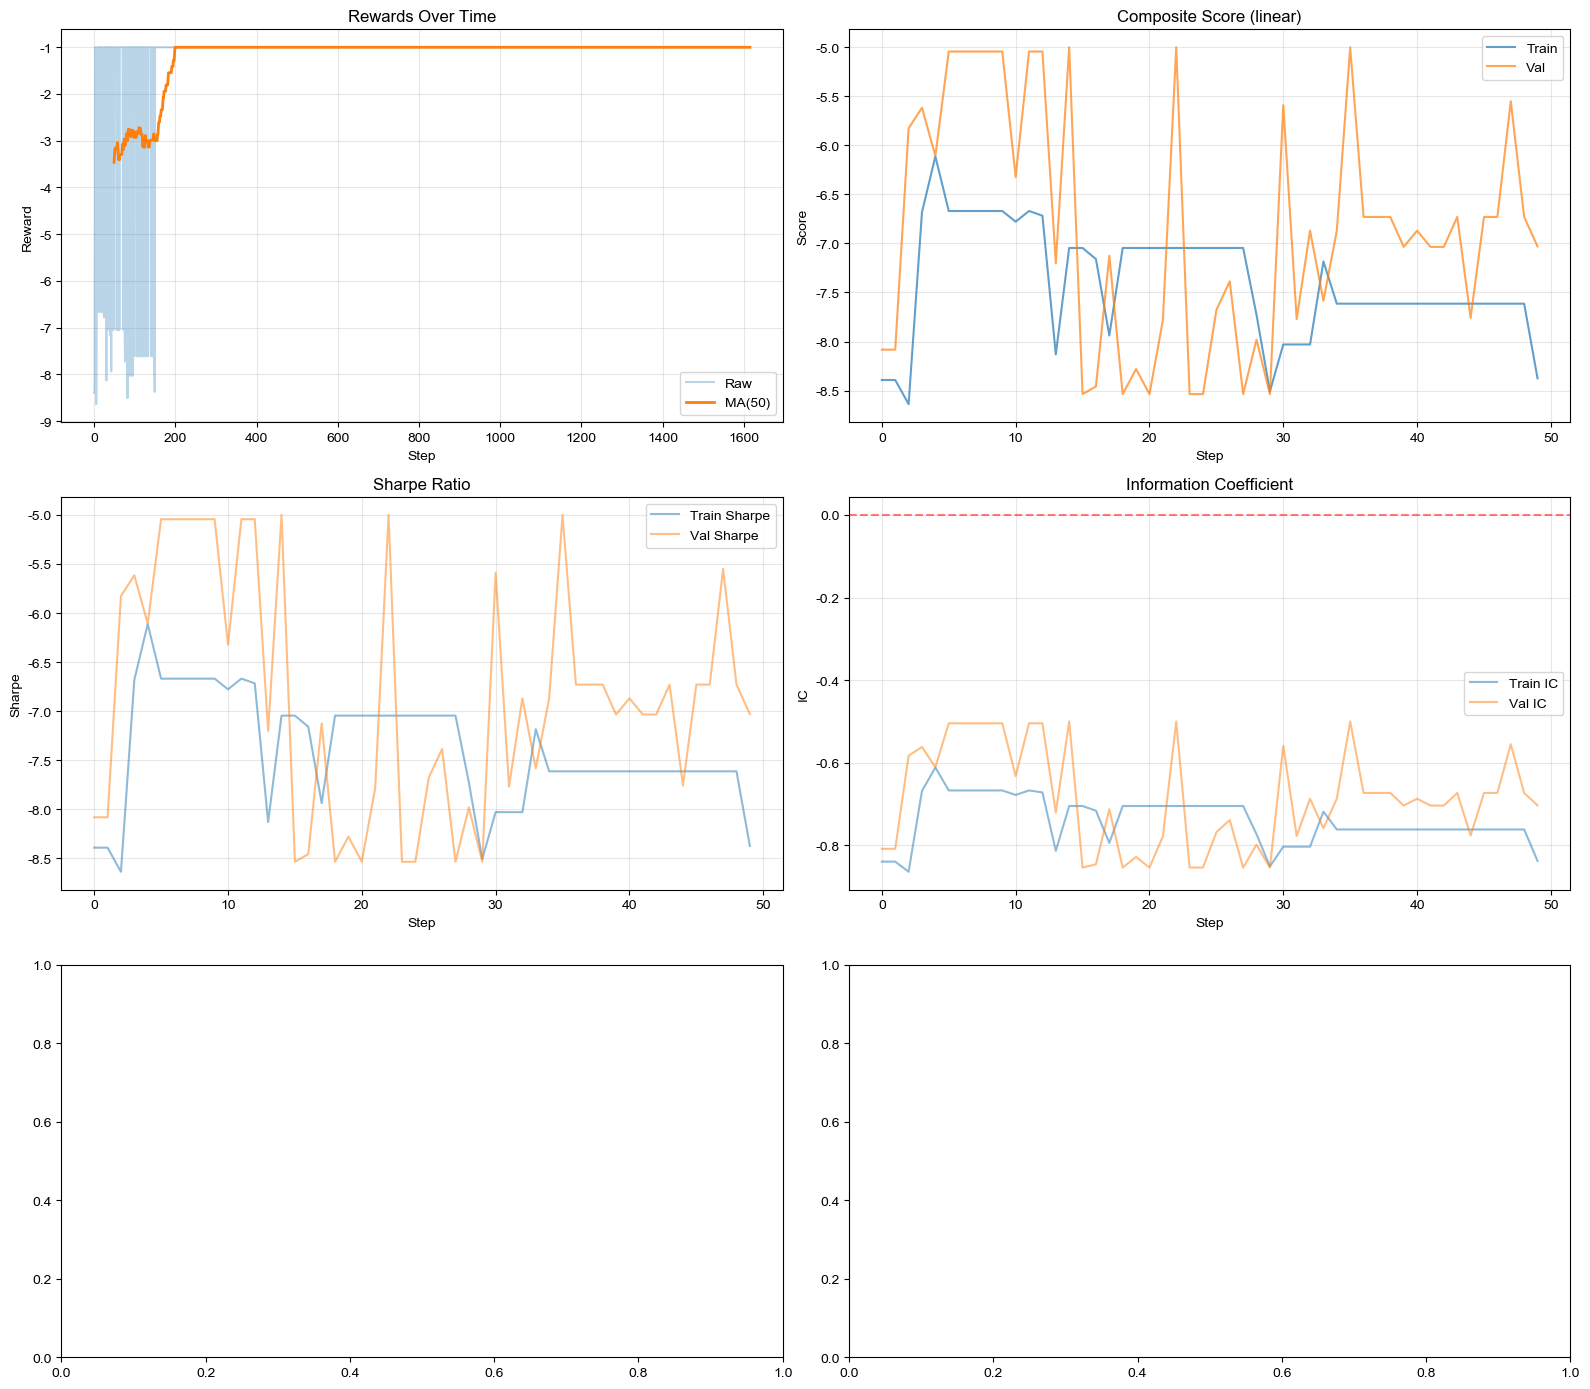

2025-11-20 15:24:51,678 - WARNING - No iteration data to analyze


In [ ]:
# ---------------------------------------------------------
# 绘制训练历史曲线
# ---------------------------------------------------------
%matplotlib inline

print("📊 正在绘制训练历史...")
miner.plot_training_history()

# 分析性能衰退情况
miner.analyze_performance_degradation()

In [ ]:
# ---------------------------------------------------------
# 对最佳因子组合进行回测
# ---------------------------------------------------------

# 创建回测器
backtester = MinerBacktester(miner)

# 在测试集上运行回测并画图
print("\n📈 开始测试集回测...")
test_results = backtester.run(
    data_split='test', 
    top_n=5, 
    save_path='test_backtest_result.png'
)

# 打印详细的单因子表现
print("\n📋 最佳单因子表现 (Top 5):")
individual_res = backtester.get_individual_results('test')
if individual_res:
    sorted_factors = sorted(individual_res.items(), key=lambda x: x[1]['sharpe_ratio'], reverse=True)[:5]
    for name, metrics in sorted_factors:
        print(f"  {name}: Sharpe={metrics['sharpe_ratio']:.2f}, IC={metrics['ic']:.4f}")

✅ 回测器已创建，因子池大小: 10

📈 开始测试集回测...

📊 完整回测并画图：TEST 数据集
数据量: 980 bars
因子池大小: 10, 回测前5个
📊 回测器初始化:
   预测周期: 10 bars
   交易成本: 0.050%
   最大持仓: 10.0%
   信号生成: 滚动分位数方法 (q_low=0.3, q_high=0.7)
   持仓策略: 始终保持持仓，中性区域1/10仓位

回测单个因子...
  Factor 0 (high): IC=-0.163, Sharpe=-2.62, Return=-2.0%
  Factor 1 (open): IC=-0.160, Sharpe=-3.26, Return=-2.4%
  Factor 2 (high): IC=-0.163, Sharpe=-2.62, Return=-2.0%
  Factor 3 (low_mad20): IC=0.008, Sharpe=0.61, Return=0.4%
  Factor 4 (high_delta1): IC=-0.099, Sharpe=-1.40, Return=-0.9%

回测因子组合...


IndexError: index 0 is out of bounds for axis 0 with size 0